# Modelo de Clasificación de Imágenes Cerebrales con CNN

Este notebook implementa una Red Neuronal Convolucional (CNN) para clasificar imágenes cerebrales en dos categorías:

- **Normal**: Cerebros sin accidente cerebrovascular
- **Stroke**: Cerebros con accidente cerebrovascular

El modelo utilizará las imágenes ubicadas en la carpeta `data/Brain_Data_Organised` que contiene las subcarpetas 'Normal' y 'Stroke'.

## 1. Importación de Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Bibliotecas para procesamiento de imágenes
import cv2
from PIL import Image

# Bibliotecas de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Configuración para visualizaciones
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline

## 2. Configuración de Rutas y Parámetros

In [2]:
# Rutas de datos
DATA_DIR = '../data/Brain_Data_Organised'
NORMAL_DIR = os.path.join(DATA_DIR, 'Normal')
STROKE_DIR = os.path.join(DATA_DIR, 'Stroke')

# Parámetros para el modelo
IMG_SIZE = 224  # Tamaño de las imágenes (224x224 es común para muchas arquitecturas CNN)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Verificar las rutas
print(f'Ruta de datos: {DATA_DIR}')
print(f'Ruta de imágenes normales: {NORMAL_DIR}')
print(f'Ruta de imágenes con stroke: {STROKE_DIR}')

Ruta de datos: ../data/Brain_Data_Organised
Ruta de imágenes normales: ../data/Brain_Data_Organised\Normal
Ruta de imágenes con stroke: ../data/Brain_Data_Organised\Stroke


## 3. Exploración de Datos

Vamos a explorar la cantidad de imágenes en cada categoría y visualizar algunas muestras.

Número de imágenes normales: 1551
Número de imágenes con stroke: 950


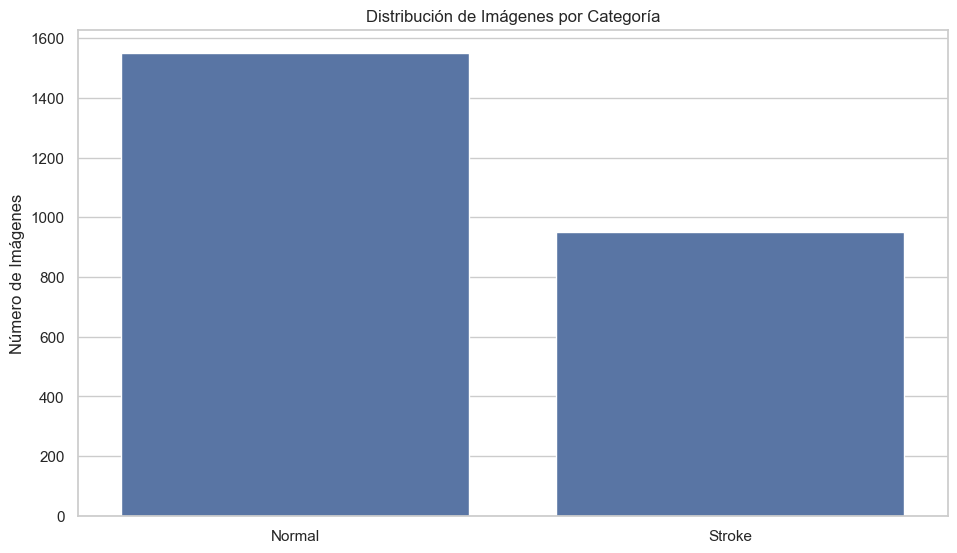

In [3]:
# Contar imágenes en cada categoría
normal_images = os.listdir(NORMAL_DIR)
stroke_images = os.listdir(STROKE_DIR)

print(f'Número de imágenes normales: {len(normal_images)}')
print(f'Número de imágenes con stroke: {len(stroke_images)}')

# Visualizar la distribución
plt.figure(figsize=(10, 6))
sns.barplot(x=['Normal', 'Stroke'], y=[len(normal_images), len(stroke_images)])
plt.title('Distribución de Imágenes por Categoría')
plt.ylabel('Número de Imágenes')
plt.show()

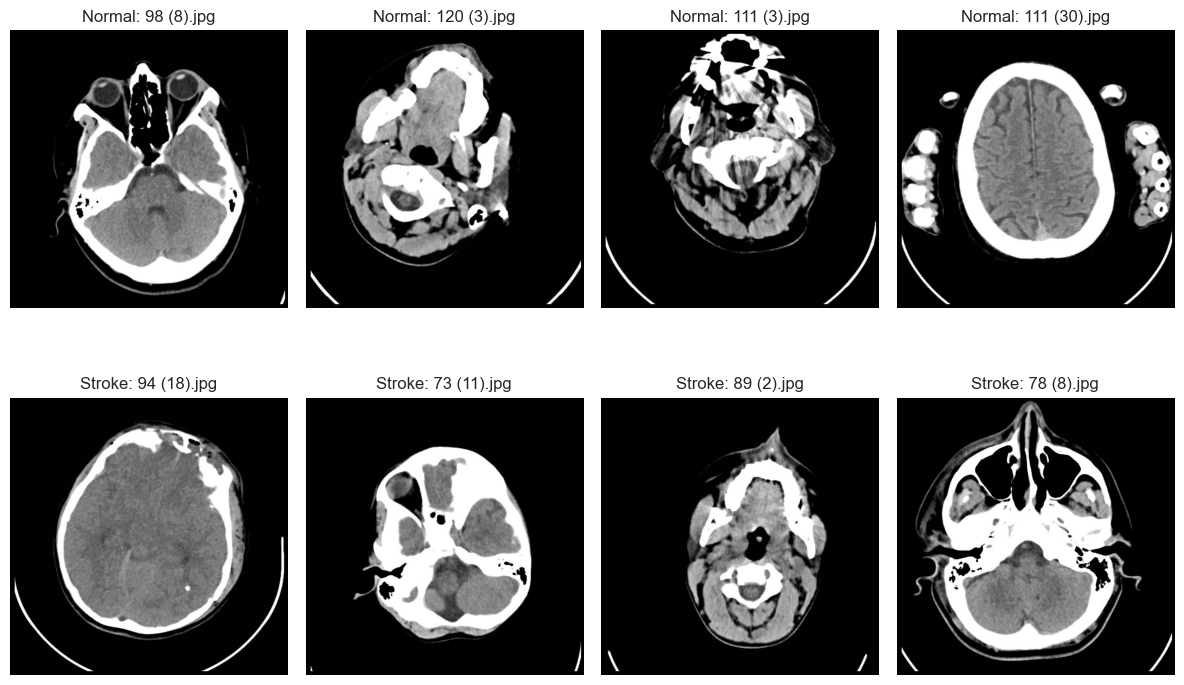

In [4]:
# Función para visualizar algunas imágenes de muestra
def visualize_sample_images(normal_dir, stroke_dir, num_samples=3):
    plt.figure(figsize=(12, 8))
    
    # Imágenes normales
    normal_samples = np.random.choice(os.listdir(normal_dir), num_samples, replace=False)
    for i, img_name in enumerate(normal_samples):
        img_path = os.path.join(normal_dir, img_name)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Normal: {img_name}')
        plt.axis('off')
    
    # Imágenes con stroke
    stroke_samples = np.random.choice(os.listdir(stroke_dir), num_samples, replace=False)
    for i, img_name in enumerate(stroke_samples):
        img_path = os.path.join(stroke_dir, img_name)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Stroke: {img_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar muestras
visualize_sample_images(NORMAL_DIR, STROKE_DIR, num_samples=4)

## 4. Preprocesamiento de Datos

Vamos a cargar las imágenes, preprocesarlas y dividirlas en conjuntos de entrenamiento, validación y prueba.

In [9]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_data(normal_dir, stroke_dir, img_size=64):
    images = []
    labels = []
    
    # Cargar imágenes normales (etiqueta 0)
    for img_name in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(0)  # Clase 'Normal'
        except Exception as e:
            print(f'Error al cargar {img_path}: {e}')
    
    # Cargar imágenes con stroke (etiqueta 1)
    for img_name in os.listdir(stroke_dir):
        img_path = os.path.join(stroke_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(1)  # Clase 'Stroke'
        except Exception as e:
            print(f'Error al cargar {img_path}: {e}')
    
    # Convertir a arrays de NumPy
    X = np.array(images)
    y = np.array(labels)
    
    # Normalizar los valores de píxeles a [0, 1]
    X = X / 255.0
    
    return X, y

# Cargar y preprocesar los datos
print('Cargando y preprocesando imágenes...')
X, y = load_and_preprocess_data(NORMAL_DIR, STROKE_DIR, img_size=IMG_SIZE)

print(f'Forma de X: {X.shape}')
print(f'Forma de y: {y.shape}')
print(f'Distribución de clases: {np.bincount(y)}')

Cargando y preprocesando imágenes...
Forma de X: (2501, 224, 224, 3)
Forma de y: (2501,)
Distribución de clases: [1551  950]


In [10]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
# Primero dividimos en entrenamiento y un conjunto temporal
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Luego dividimos el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1750, 224, 224, 3), y_train shape: (1750,)
X_val shape: (375, 224, 224, 3), y_val shape: (375,)
X_test shape: (376, 224, 224, 3), y_test shape: (376,)


## 5. Aumento de Datos (Data Augmentation)

Aplicamos técnicas de aumento de datos para mejorar la generalización del modelo.

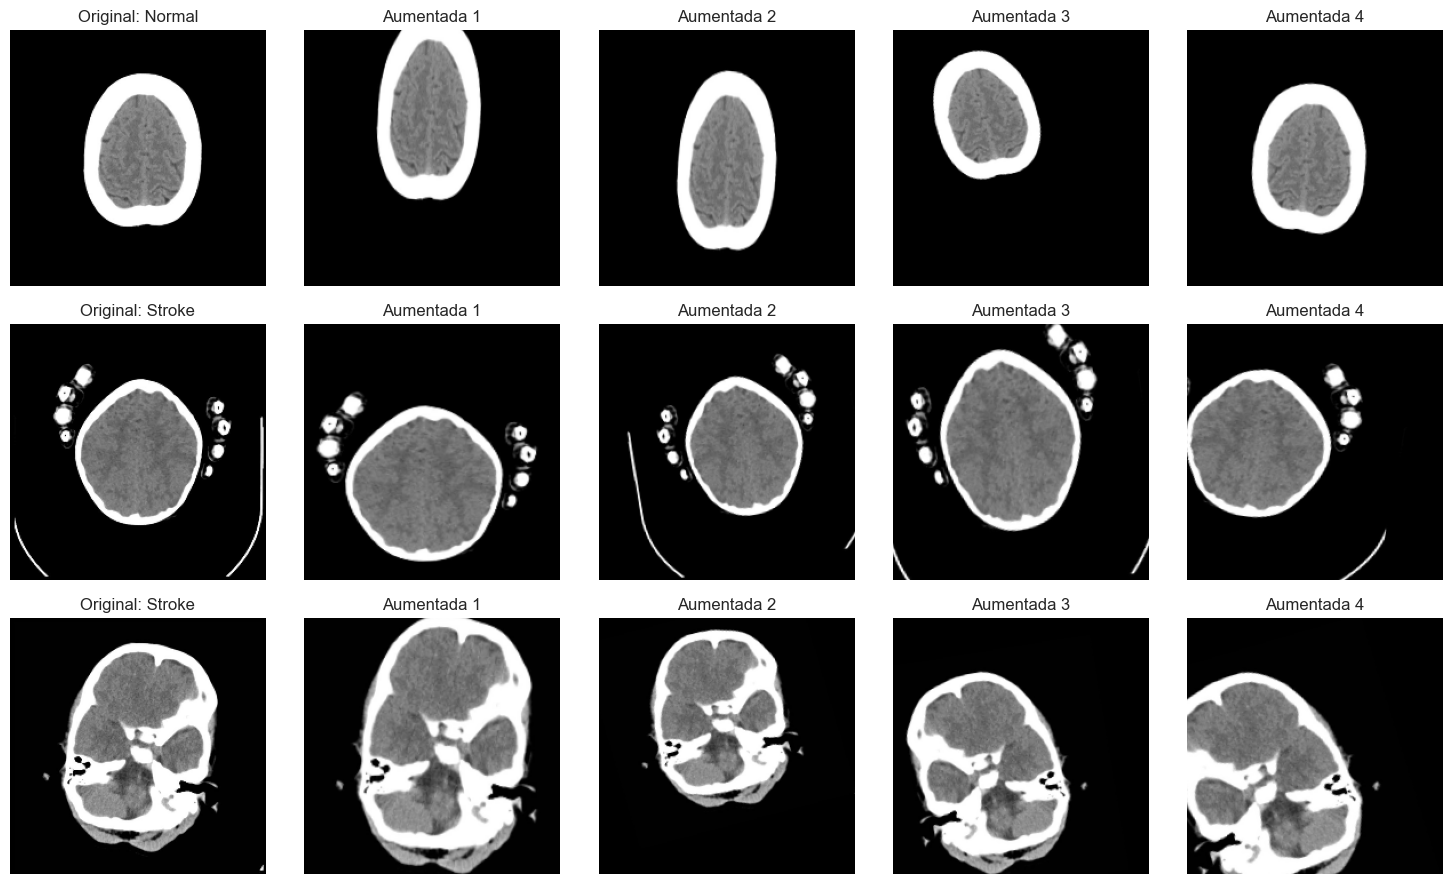

In [11]:
# Configurar el generador de datos para aumento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualizar algunas imágenes aumentadas
def visualize_augmented_images(X_sample, y_sample, datagen, num_images=5):
    # Tomar una muestra de imágenes
    indices = np.random.choice(range(len(X_sample)), num_images, replace=False)
    X_subset = X_sample[indices]
    y_subset = y_sample[indices]
    
    # Configurar el generador para una sola imagen
    sample_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    plt.figure(figsize=(15, 3*num_images))
    
    for i, (image, label) in enumerate(zip(X_subset, y_subset)):
        # Mostrar imagen original
        plt.subplot(num_images, 5, i*5+1)
        plt.imshow(image)
        plt.title(f'Original: {"Normal" if label == 0 else "Stroke"}')
        plt.axis('off')
        
        # Generar y mostrar 4 versiones aumentadas
        image = image.reshape((1,) + image.shape)  # Reshape para el generador
        augmented_images = [next(sample_datagen.flow(image, batch_size=1))[0] for _ in range(4)]
        
        for j, aug_img in enumerate(augmented_images):
            plt.subplot(num_images, 5, i*5+j+2)
            plt.imshow(aug_img)
            plt.title(f'Aumentada {j+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar algunas imágenes aumentadas
visualize_augmented_images(X_train, y_train, datagen, num_images=3)

## 6. Construcción del Modelo CNN

Definimos una arquitectura CNN para la clasificación de imágenes cerebrales.

In [12]:
def build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = Sequential()
    
    # Primera capa convolucional
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Segunda capa convolucional
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Tercera capa convolucional
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Cuarta capa convolucional
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Aplanar y capas densas
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria (Normal vs Stroke)
    
    # Compilar el modelo
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 'Precision', 'Recall']
    )
    
    return model

# Construir el modelo
model = build_cnn_model()

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_11 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                      

## 7. Entrenamiento del Modelo

Entrenamos el modelo con los datos de entrenamiento y validamos con el conjunto de validación.

In [ ]:
# Configurar callbacks para el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('../model/brain_stroke_cnn_best.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Entrenar el modelo con aumento de datos
print('Entrenando el modelo...')
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Entrenando el modelo...
Epoch 1/20


30/54 [===============>..............] - ETA: 27s - loss: 1.0269 - accuracy: 0.5116 - auc: 0.4972 - precision: 0.3978 - recall: 0.4812

## 8. Visualización del Entrenamiento

Visualizamos las métricas de entrenamiento para analizar el rendimiento del modelo.

In [ ]:
# Función para visualizar las métricas de entrenamiento
def plot_training_history(history):
    # Lista de métricas a visualizar
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    
    # Crear una figura con subplots
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, metric in enumerate(metrics):
        # Obtener el nombre de la métrica para entrenamiento y validación
        train_metric = metric
        val_metric = 'val_' + metric
        
        # Verificar si la métrica existe en el historial
        if train_metric in history.history and val_metric in history.history:
            # Graficar la métrica
            axes[i].plot(history.history[train_metric], label=f'Training {metric}')
            axes[i].plot(history.history[val_metric], label=f'Validation {metric}')
            axes[i].set_title(f'{metric.capitalize()} durante el entrenamiento')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend()
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar el historial de entrenamiento
plot_training_history(history)

## 9. Evaluación del Modelo

Evaluamos el modelo en el conjunto de prueba y visualizamos los resultados.

In [ ]:
# Cargar el mejor modelo guardado
best_model = load_model('../model/brain_stroke_cnn_best.h5')

# Evaluar el modelo en el conjunto de prueba
print('Evaluando el modelo en el conjunto de prueba...')
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test, y_test)

print(f'Resultados en el conjunto de prueba:')
print(f'Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'AUC: {test_auc:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Mostrar el reporte de clasificación
print('Reporte de Clasificación:')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Stroke']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Normal', 'Stroke'],
           yticklabels=['Normal', 'Stroke'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 10. Visualización de Predicciones

Visualizamos algunas predicciones del modelo para entender mejor su rendimiento.

In [ ]:
# Función para visualizar predicciones
def visualize_predictions(X, y_true, y_pred, y_pred_prob, num_samples=10):
    # Seleccionar muestras aleatorias
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    # Crear una figura con subplots
    plt.figure(figsize=(15, num_samples * 2))
    
    for i, idx in enumerate(indices):
        # Obtener la imagen y las etiquetas
        img = X[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_pred_prob[idx][0]
        
        # Determinar el color del borde según la predicción
        border_color = 'green' if true_label == pred_label else 'red'
        
        # Mostrar la imagen
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.title(f'Real: { 'Normal' if true_label == 0 else 'Stroke'}, ' + 
 
                  f'Predicción: { 'Normal' if pred_label == 0 else 'Stroke'} ' +
 
                  f'(Prob: {prob:.2f})', color=border_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar algunas predicciones
visualize_predictions(X_test, y_test, y_pred, y_pred_prob, num_samples=8)

## 11. Función para Predicciones en Nuevas Imágenes

Creamos una función para realizar predicciones en nuevas imágenes.

In [ ]:
def predict_brain_image(image_path, model, img_size=224):
    """
    Realiza una predicción en una nueva imagen cerebral.
    
    Args:
        image_path: Ruta a la imagen cerebral
        model: Modelo entrenado
        img_size: Tamaño de la imagen para el modelo
    
    Returns:
        prediction: Etiqueta predicha (0: Normal, 1: Stroke)
        probability: Probabilidad de la predicción
    """
    # Cargar y preprocesar la imagen
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalizar
    img = np.expand_dims(img, axis=0)  # Añadir dimensión de lote
    
    # Realizar la predicción
    prob = model.predict(img)[0][0]
    prediction = 1 if prob > 0.5 else 0
    
    return prediction, prob

# Ejemplo de uso de la función
# Seleccionar una imagen aleatoria del conjunto de prueba
random_idx = np.random.randint(0, len(X_test))
test_img_path = os.path.join(STROKE_DIR if y_test[random_idx] == 1 else NORMAL_DIR, 
                            os.listdir(STROKE_DIR if y_test[random_idx] == 1 else NORMAL_DIR)[0])

print(f'Imagen de prueba: {test_img_path}')
prediction, probability = predict_brain_image(test_img_path, best_model)

print(f'Predicción: { ' Normal ' if prediction == 0 else 'Stroke'}')
print(f'Probabilidad: {probability:.4f}')

## 12. Conclusiones

En este notebook, hemos desarrollado un modelo de CNN para clasificar imágenes cerebrales en dos categorías: Normal y Stroke (accidente cerebrovascular). El modelo ha sido entrenado con técnicas de aumento de datos para mejorar su generalización y evaluado con métricas relevantes para problemas de clasificación médica.

### Resumen del Proceso:

1. **Exploración de Datos**: Analizamos la distribución de imágenes en ambas categorías.
2. **Preprocesamiento**: Cargamos, redimensionamos y normalizamos las imágenes.
3. **Aumento de Datos**: Aplicamos técnicas de aumento para mejorar la generalización.
4. **Arquitectura CNN**: Diseñamos una red convolucional profunda con múltiples capas.
5. **Entrenamiento**: Entrenamos el modelo con early stopping y reducción de tasa de aprendizaje.
6. **Evaluación**: Evaluamos el modelo con métricas como precisión, recall, F1-score y AUC.

### Posibles Mejoras:

- Probar arquitecturas más avanzadas como ResNet, DenseNet o EfficientNet.
- Implementar técnicas de transfer learning con modelos preentrenados.
- Explorar técnicas de interpretabilidad como mapas de activación o Grad-CAM.
- Aumentar el conjunto de datos con más imágenes médicas.

Este modelo puede servir como una herramienta de apoyo para profesionales médicos en la detección temprana de accidentes cerebrovasculares, aunque siempre debe ser utilizado bajo supervisión médica y como complemento al diagnóstico clínico.